# Carregamento das Bibliotecas

In [1]:
%env TF_CPP_MIN_LOG_LEVEL = 3

env: TF_CPP_MIN_LOG_LEVEL=3


In [2]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gymnasium as gym
import gym_anytrading
import stable_baselines3
from gym_anytrading.envs import Actions
from stable_baselines3 import PPO

# Módulo de Extração dos Dados Históricos

In [3]:
def get_stock_data(ticker):

    start_date = '2014-08-23'
    end_date = '2024-08-23'

    date = yf.download(ticker, start = start_date, end = end_date).index
    dados = yf.download(ticker, start=start_date, end=end_date)['Close']
    dados.rename(columns={'MSFT': 'Close'}, inplace=True)
    dados.reset_index(drop=True, inplace=True)
    dados['Date'] = pd.to_datetime(date)
    dados.set_index('Date', inplace=True)

    return dados

In [4]:
df = get_stock_data('MSFT')

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [5]:
df.shape

(2516, 1)

In [6]:
df.head()

Ticker,Close
Date,
2014-08-25,38.544071
2014-08-26,38.407528
2014-08-27,38.288067
2014-08-28,38.296597
2014-08-29,38.765911


In [7]:
df.tail()

Ticker,Close
Date,
2024-08-16,417.634033
2024-08-19,420.687927
2024-08-20,423.951385
2024-08-21,423.292725
2024-08-22,414.719879


# Janela de Lookback

In [8]:
window_size = 10
start_index = window_size
end_index = len(df)

# Criação do Ambiente de Negociação

In [9]:
df_env = gym.make('stocks-v0',
                  df = df,
                  window_size= window_size,
                  frame_bound = (start_index, end_index))

In [10]:
print("Espaço de Obervação:", df_env.observation_space)

Espaço de Obervação: Box(-10000000000.0, 10000000000.0, (10, 2), float32)


# Definindo o Saldo Inicial Para Negociação e Outros Parâmetros

In [11]:
saldo = 100000
historico_saldo = [saldo]
num_acoes_manter = 0
status_decisao = {Actions.Sell: 0, Actions.Buy: 0}

In [12]:
observation, info = df_env.reset(seed = 42)

# Criação e Treinamento do Modelo

In [13]:
modelo_trading = PPO('MlpPolicy', df_env, seed = 42, verbose = 1)

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


/home/renan/anaconda3/envs/finan/lib/python3.11/site-packages/stable_baselines3/common/on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(


In [14]:
modelo_trading.learn(total_timesteps= 10000)

-----------------------------
| time/              |      |
|    fps             | 738  |
|    iterations      | 1    |
|    time_elapsed    | 2    |
|    total_timesteps | 2048 |
-----------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 2.5e+03      |
|    ep_rew_mean          | 105          |
| time/                   |              |
|    fps                  | 658          |
|    iterations           | 2            |
|    time_elapsed         | 6            |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 0.0004895631 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.693       |
|    explained_variance   | 9.71e-05     |
|    learning_rate        | 0.0003       |
|    loss                 | 5.67         |
|    n_updates            | 10           |
|    policy_grad

# Executando o Agente de Trading no Ambiente de Negociação

In [15]:
step = 0

while True:

    action, _states = modelo_trading.predict(observation)
    current_price = df_env.unwrapped.prices[df_env.unwrapped._current_tick]
    observation, reward, terminated, truncated, info = df_env.step(action)
    trade_amount = saldo * 0.10

    if action == Actions.Buy.value:
        shares_to_buy = trade_amount / current_price
        num_acoes_manter += shares_to_buy
        saldo -= trade_amount
        print(f'{step}: Comprar {shares_to_buy:.2f} ações por ${current_price:.2f} cada uma | Saldo: ${saldo:.2f}')

    elif action == Actions.Sell.value and num_acoes_manter > 0:
        saldo += num_acoes_manter * current_price
        print(f'{step}:  Vender {num_acoes_manter:.2f} ações por ${current_price:.2f} cada uma | Saldo: ${saldo:.2f}')
        num_acoes_manter = 0

    else:
        print(f'{step}: Manter | Valor Corrente da Ação: ${current_price:.2f} | Saldo: ${saldo:.2f}')

    status_decisao[Actions(action)] += 1
    historico_saldo.append(saldo)
    step += 1

    if terminated or truncated:
        break

0: Manter | Valor Corrente da Ação: $39.99 | Saldo: $100000.00
1: Manter | Valor Corrente da Ação: $39.47 | Saldo: $100000.00
2: Manter | Valor Corrente da Ação: $39.47 | Saldo: $100000.00
3: Manter | Valor Corrente da Ação: $40.29 | Saldo: $100000.00
4: Manter | Valor Corrente da Ação: $40.81 | Saldo: $100000.00
5: Manter | Valor Corrente da Ação: $40.65 | Saldo: $100000.00
6: Manter | Valor Corrente da Ação: $40.74 | Saldo: $100000.00
7: Manter | Valor Corrente da Ação: $41.38 | Saldo: $100000.00
8: Manter | Valor Corrente da Ação: $41.41 | Saldo: $100000.00
9: Manter | Valor Corrente da Ação: $40.58 | Saldo: $100000.00
10: Comprar 245.80 ações por $40.68 cada uma | Saldo: $90000.00
11:  Vender 245.80 ações por $41.20 cada uma | Saldo: $100126.23
12: Manter | Valor Corrente da Ação: $40.40 | Saldo: $100126.23
13: Manter | Valor Corrente da Ação: $40.68 | Saldo: $100126.23
14: Manter | Valor Corrente da Ação: $40.67 | Saldo: $100126.23
15: Manter | Valor Corrente da Ação: $40.91 | Sal

# Decisão Final do Agente

In [16]:
if num_acoes_manter > 0:
    saldo += num_acoes_manter * current_price
    print(f'Venda Final de {num_acoes_manter:.2f} ações por ${current_price:.2f} cada uma | Saldo: ${saldo:.2f}')
    num_acoes_manter = 0

In [17]:
df_env.close()

In [18]:
modelo_trading.save('modelo_trading')

# Resultado Obtido Pelo Agente de Trading

In [19]:
print(f'Decisões Tomadas: {status_decisao}')
print(f'Saldo Final: ${saldo:.2f}')

Decisões Tomadas: {<Actions.Sell: 0>: 1539, <Actions.Buy: 1>: 746}
Saldo Final: $109836.29


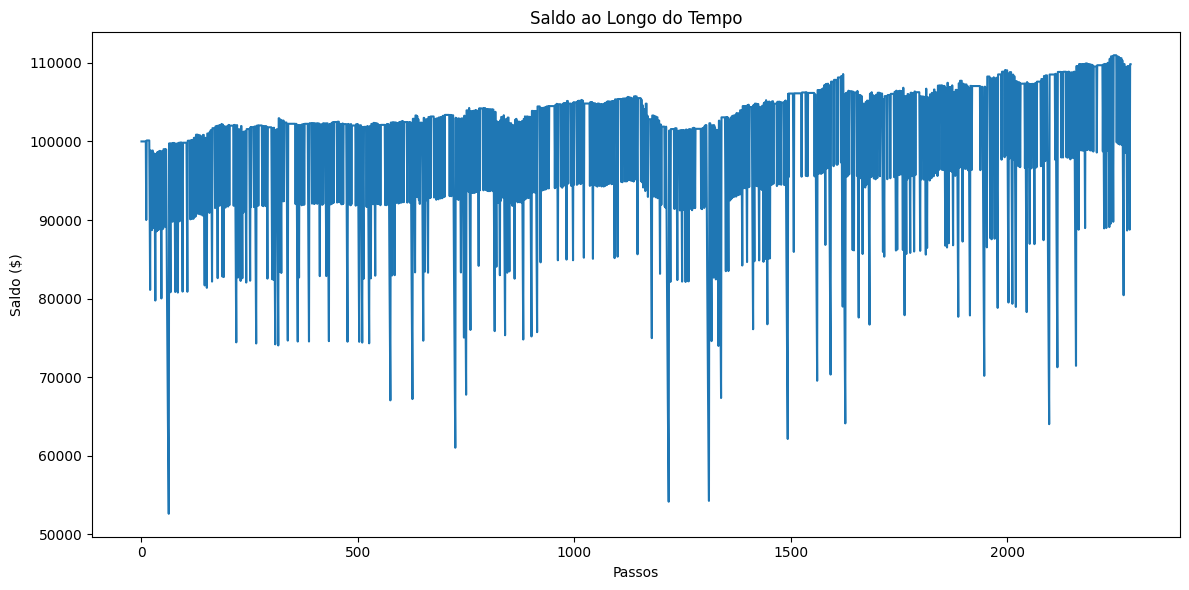

In [20]:
fig2, ax2 = plt.subplots(figsize=(12, 6))
ax2.plot(historico_saldo)

ax2.set_title('Saldo ao Longo do Tempo')
ax2.set_xlabel('Passos')
ax2.set_ylabel('Saldo ($)')

fig2.tight_layout()
plt.show()

# Usando o Agente de Trading Para Períodos Futuros

In [21]:
modelo_trading = PPO.load('modelo_trading.zip', device='cpu')

In [22]:
new_df = yf.download('MSFT', start= '2024-08-24', end='2024-12-20')

[*********************100%***********************]  1 of 1 completed


In [23]:
new_date = yf.download('MSFT', start= '2024-08-24', end= '2024-12-20').index

[*********************100%***********************]  1 of 1 completed


In [24]:
new_df.columns = new_df.columns.droplevel(1)

In [25]:
new_df.reset_index(drop=True, inplace=True)
new_df['Date'] = pd.to_datetime(new_date)
new_df.set_index('Date', inplace=True)

In [26]:
new_df.columns

Index(['Close', 'High', 'Low', 'Open', 'Volume'], dtype='object', name='Price')

In [27]:
new_df.head()

Price,Close,High,Low,Open,Volume
Date,,,,,
2024-08-26,412.663971,416.446408,410.518272,415.538223,13152800
2024-08-27,413.013275,413.532225,409.430450,412.035222,13492900
2024-08-28,409.779785,414.170990,406.496349,414.051234,14882700
2024-08-29,412.294739,421.206893,409.779784,414.111110,17045200
2024-08-30,416.306702,416.655978,411.306700,414.769770,24308300


In [28]:
new_df.tail()

Price,Close,High,Low,Open,Volume
Date,,,,,
2024-12-13,447.269989,451.429993,445.579987,448.440002,20177800
2024-12-16,451.589996,452.179993,445.279999,447.269989,23598800
2024-12-17,454.459991,455.290009,449.570007,451.010010,22733500
2024-12-18,437.390015,452.649994,437.019989,451.320007,24444500
2024-12-19,437.029999,443.179993,436.320007,441.619995,22963700


In [29]:
window_size= 10

In [30]:
frame_bound = (window_size, len(new_df))

In [31]:
new_env = gym.make('stocks-v0',
                   df = new_df,
                   window_size= window_size,
                   frame_bound= frame_bound)

In [32]:
observation, info = new_env.reset(seed = 42)

In [35]:
novo_saldo = 150000
novo_num_acoes_manter = 0
novo_historico_saldo = [novo_saldo]

In [36]:
while True:

    action, _states = modelo_trading.predict(observation)
    current_price = new_env.unwrapped.prices[new_env.unwrapped._current_tick]
    observation, reward, terminated, truncated, info = new_env.step(action)
    trade_amount = novo_saldo * 0.10

    if action == Actions.Buy.value:
        shares_to_buy = trade_amount / current_price
        novo_num_acoes_manter += shares_to_buy
        novo_saldo -= trade_amount
        print(f'Comprar: {shares_to_buy:.2f} ações por ${current_price:.2f} cada uma | Novo Saldo: ${novo_saldo:.2f}')

    elif action == Actions.Sell.value and novo_num_acoes_manter > 0:
        novo_saldo += novo_num_acoes_manter * current_price
        print(f'Vender: {novo_num_acoes_manter:.2f} ações por ${current_price:.2f} cada uma | Novo Saldo: ${novo_saldo:.2f}')
        novo_num_acoes_manter = 0

    else:
        print(f'Manter | Preço da Ação: ${current_price:.2f} | Saldo: ${novo_saldo:.2f}')

    novo_historico_saldo.append(novo_saldo)

    if terminated or truncated:
        break

Manter | Preço da Ação: $422.19 | Saldo: $150000.00
Manter | Preço da Ação: $426.15 | Saldo: $150000.00
Comprar: 34.91 ações por $429.73 cada uma | Novo Saldo: $135000.00
Comprar: 31.36 ações por $430.48 cada uma | Novo Saldo: $121500.00
Vender: 66.27 ações por $434.28 cada uma | Novo Saldo: $150278.10
Comprar: 34.95 ações por $429.95 cada uma | Novo Saldo: $135250.29
Vender: 34.95 ações por $437.81 cada uma | Novo Saldo: $150552.97
Manter | Preço da Ação: $434.40 | Saldo: $150552.97
Comprar: 34.80 ações por $432.64 cada uma | Novo Saldo: $135497.68
Vender: 34.80 ações por $428.31 cada uma | Novo Saldo: $150402.25
Manter | Preço da Ação: $431.25 | Saldo: $150402.25
Comprar: 34.94 ações por $430.45 cada uma | Novo Saldo: $135362.02
Vender: 34.94 ações por $427.16 cada uma | Novo Saldo: $150287.52
Manter | Preço da Ação: $429.44 | Saldo: $150287.52
Manter | Preço da Ação: $419.85 | Saldo: $150287.52
Manter | Preço da Ação: $416.30 | Saldo: $150287.52
Manter | Preço da Ação: $415.71 | Sal

In [38]:
if novo_num_acoes_manter > 0:
    novo_saldo += novo_num_acoes_manter * current_price
    print(f'Venda Final: {novo_num_acoes_manter:.2f} ações por ${current_price:.2f} caada uma | Saldo Final: ${novo_saldo:.2f}')

In [39]:
novo_num_acoes_manter

0